In [2]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/src/'
sys.path.insert(0, src_dir)

# GRB pop module imports
from GRB_population import GRBPopulation
import physics as ph
import stats as st
import io_grb_pop as io
from io_grb_pop import root_dir
import miscellaneous as msc
import plotting_functions as pf
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
import cosmology as cs
import f90_functions as f90f

# General imports
import yaml
import logging
import corner
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s.%(msecs)03d [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
plt.style.use('paper')
colors = ['#225ea8', '#41b6c4', '#d94801', '#fd8d3c']
Nb_GRBs_glob = int(1e5)
save_fig = False

Creating cosmology with: OmegaM = 0.27, OmegaL = 0.73, H0 = 70.0
17:50:55.989 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
17:50:55.991 [INFO] Including instruments: ['BATSE', 'BAT']
17:50:55.992 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
17:50:56.065 [INFO] Debug mode activated; plotting z pdf
17:50:56.141 [INFO] Debug mode activated; plotting L pdf
17:50:56.186 [INFO] Debug mode activated; plotting Ep pdf
17:50:56.239 [INFO] Debug mode activated; plotting spectral params pdf
17:50:56.316 [INFO] Starting calculations of peak photon fluxes...
17:50:57.327 [INFO] Debug mode activated; plotting t90 pdf
17:50:57.510 [INFO] Debug mode activated; plotting Cvar pdf
17:50:57.561 [INFO] Starting calculations of peak photon fluxes...
17:50:58.418 [INFO] Starting calculations of peak energy fluxes...
17:50:59.844 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|           

17:51:00.476 [INFO] In compute_CDF_bounds_by_MC: starting Monte Carlo drawings...
17:51:00.496 [INFO] In compute_CDF_bounds_by_MC: starting bootstraps...
17:51:00.541 [INFO] In compute_CDF_bounds_by_MC: computing CDF...


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


17:51:02.396 [INFO] In compute_CDF_bounds_by_MC: plotting...


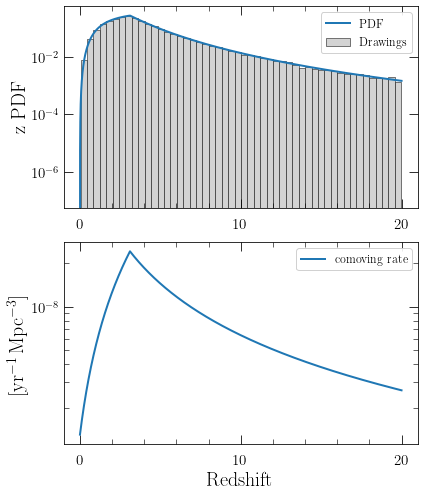

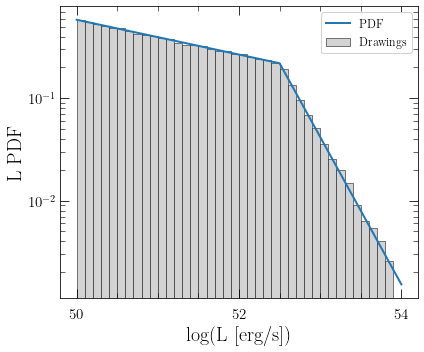

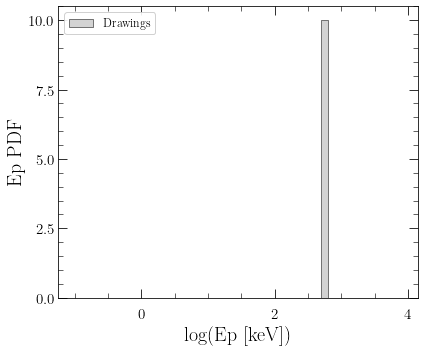

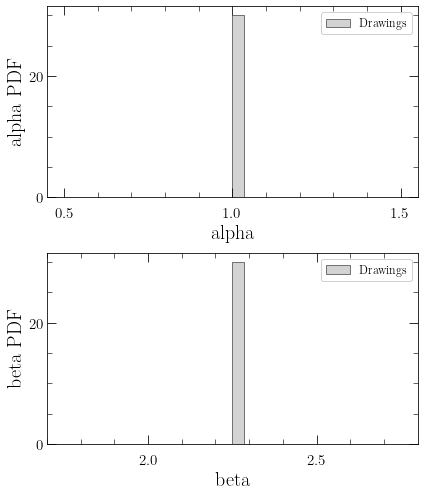

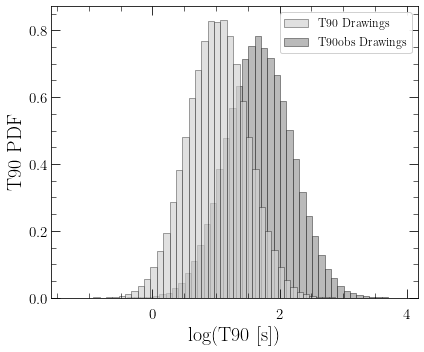

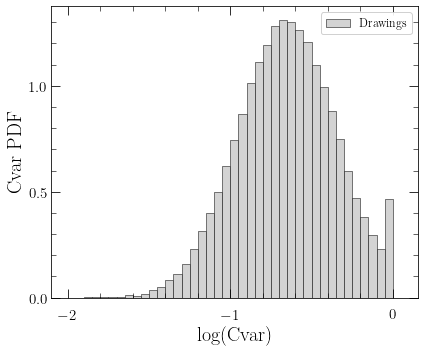

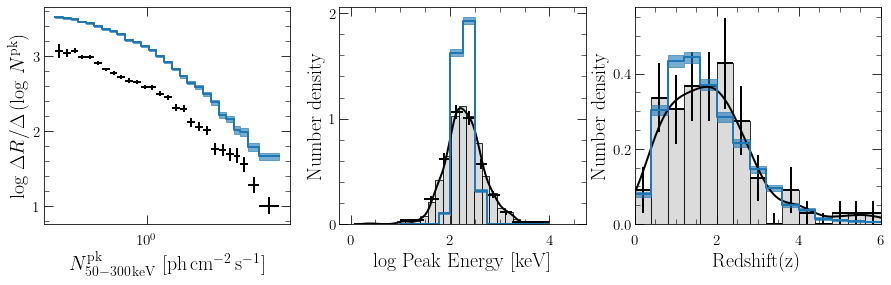

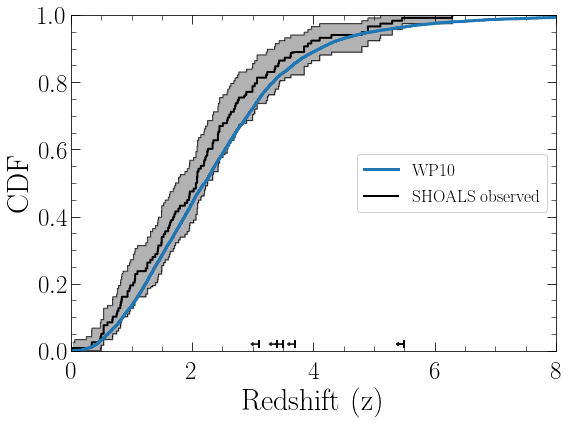

In [4]:
# Wanderman & Piran 2010
WP10 = True
nGRB0 = 1.3e-9 # yr-1 Mpc-3
nGRB0_err = 0.65e-9 # yr-1 Mpc-3
if WP10:
    lab = 'WP10'
    paths_to_dir, paths_to_files = io.generate_paths()
    config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
    # Cosmology is slightly different (h=0.7 instead of 0.71)
    cosmo = cs.create_cosmology(OmegaM=0.27, OmegaL=0.73, h=0.7, zmax=100)
    params['luminosity_function']={'model':'EBPL',
                                  'logLbreak':52.5,
                                  'slopeL':1.17,
                                  'slopeH':2.44,
                                  'logLmin':50,
                                  'logLmax':54,
                                  'k_evol':0}
    params['redshift_distribution']={'model':'BPL',
                                    'zm':3.11,
                                    'a':2.07,
                                    'b':-1.36}
    params['peak_energy_distribution']={'model':'Fixed',
                                    'Ep0':511.}
    params['spectral_shape']={'model':'FBand',
                                    'alpha':1,
                                    'beta':2.25}
    config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
    incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                           samples=samples,
                                                           instruments=instruments,
                                                           obs_constraints=obs_constraints)
    ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                ECLAIRs_config=instruments['ECLAIRs'])
    samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']
    gp = GRBPopulation(Nb_GRBs=Nb_GRBs_glob)
    gp.draw_GRB_properties(cosmo, params, run_mode='debug')
    gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_photon_fluence(incl_instruments)
    gp.calc_energy_fluence(incl_instruments)
    gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
    gp.create_mock_constraints()
#     gp.compare_to_observational_constraints(constraints=incl_constraints)
    gp.normalize_from(nGRB0=nGRB0, nGRB0_err=nGRB0_err)
    print(gp.summary())

    # Observational constraints
    plt.style.use('presentation')
    fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
    pf.plot_intensity_constraint(axes[0], pop=gp, label=lab)
#     pf.plot_intensity_constraint(axes[0], pop=gp, label='Alt', alt_norm=True, plot_obs=False)
    pf.plot_spectral_constraint(axes[1], pop=gp, label=lab)
    pf.plot_redshift_constraint(axes[2], pop=gp, label=lab)

    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{lab}.pdf', bbox_inches='tight')

    # SHOALS redshift distribution
    plt.style.use('paper')
    fig, ax = plt.subplots(figsize=(8,6))
    df = gp.properties
    pf.plot_SHOALS_distr(df[df['pdet_SHOALS']==1]['z'],
                          key='z',
                          plot_obs=False,
                          cumul=True,
                          ax=ax,
                          mod_color='C0',
                          mod_label=lab, linewidth=3)

    pf.plot_SHOALS_z_distr_with_bounds(ax)
    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{lab}.pdf', bbox_inches='tight')


Creating cosmology with: OmegaM = 0.3, OmegaL = 0.7, H0 = 70.0
17:57:13.700 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
17:57:13.701 [INFO] Including instruments: ['BATSE', 'BAT']
17:57:13.702 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
17:57:13.758 [INFO] Debug mode activated; plotting z pdf
17:57:13.847 [INFO] Debug mode activated; plotting L pdf
17:57:13.913 [INFO] Debug mode activated; plotting Ep pdf
17:57:13.970 [INFO] Debug mode activated; plotting spectral params pdf
17:57:14.041 [INFO] Starting calculations of peak photon fluxes...
17:57:14.929 [INFO] Debug mode activated; plotting t90 pdf
17:57:15.029 [INFO] Debug mode activated; plotting Cvar pdf
17:57:15.073 [INFO] Starting calculations of peak photon fluxes...
17:57:15.954 [INFO] Starting calculations of peak energy fluxes...
17:57:17.394 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|             

17:57:18.064 [INFO] In compute_CDF_bounds_by_MC: starting bootstraps...
17:57:18.093 [INFO] In compute_CDF_bounds_by_MC: computing CDF...


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


17:57:19.894 [INFO] In compute_CDF_bounds_by_MC: plotting...


/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


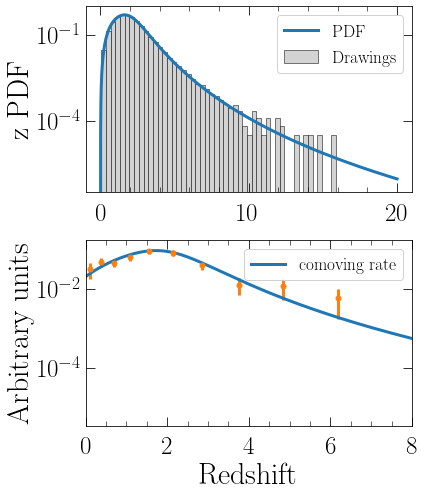

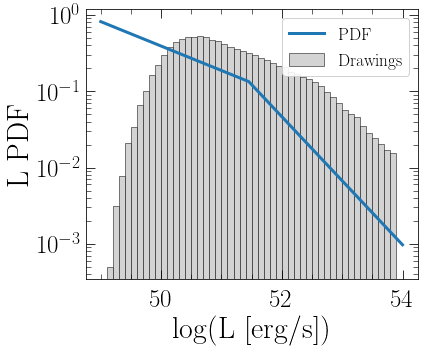

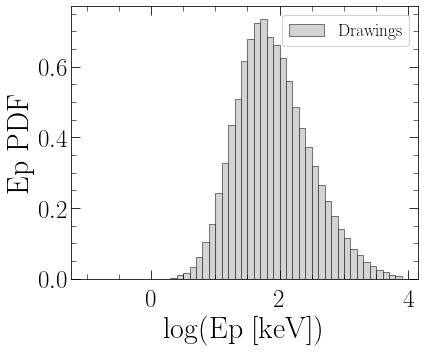

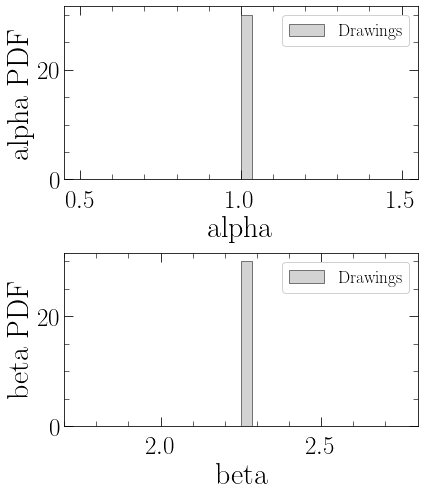

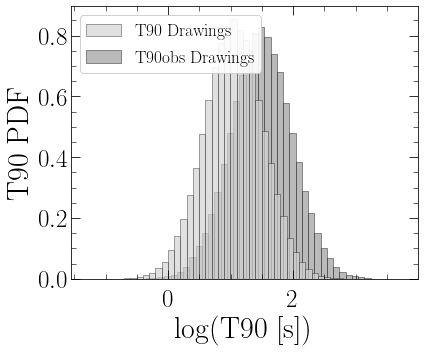

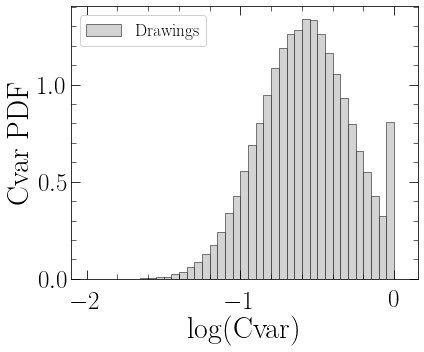

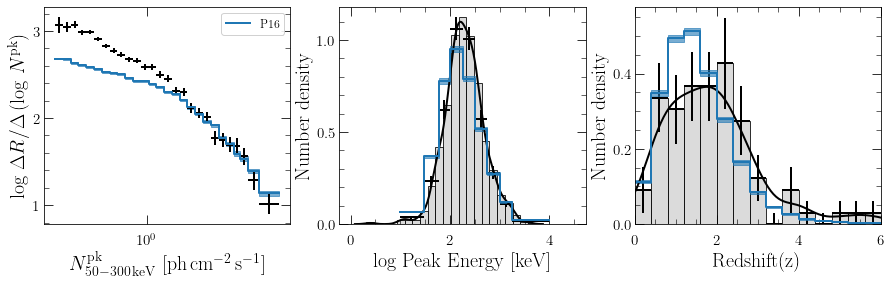

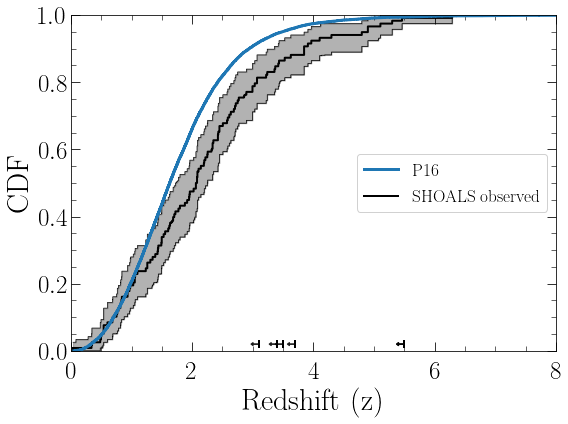

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


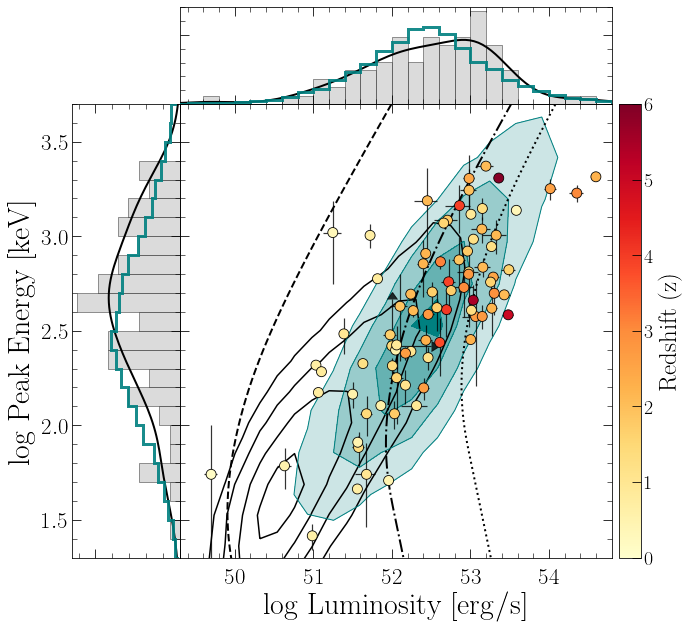

In [6]:
# Pescalli 2016
P16 = True
nGRB0 = 8e-10 # yr-1 Mpc-3
nGRB0_err = 1e-10 # yr-1 Mpc-3
if P16:
    lab = 'P16'
    color = 'teal'
    paths_to_dir, paths_to_files = io.generate_paths()
    config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
    # Cosmology is slightly different
    cosmo = cs.create_cosmology(OmegaM=0.3, OmegaL=0.7, h=0.7, zmax=100)
    params['luminosity_function']={'model':'EBPL',
                                  'logLbreak':51.45,
                                  'slopeL':1.32,
                                  'slopeH':1.84,
                                  'logLmin':49,
                                  'logLmax':54,
                                  'k_evol':2.5}
    params['redshift_distribution']={'model':'P16'}
    params['peak_energy_distribution']={'model':'A',
                                        'Ep0':309.,
                                        'alpha_amati':0.54,
                                        'sigmaEp':0.28}
    params['spectral_shape']={'model':'FBand',
                                    'alpha':1,
                                    'beta':2.25}

    config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
    incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                           samples=samples,
                                                           instruments=instruments,
                                                           obs_constraints=obs_constraints)
    ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                ECLAIRs_config=instruments['ECLAIRs'])
    samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']
    gp = GRBPopulation(Nb_GRBs=Nb_GRBs_glob)
    gp.draw_GRB_properties(cosmo, params, run_mode='debug')
    gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_photon_fluence(incl_instruments)
    gp.calc_energy_fluence(incl_instruments)
    gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
    gp.create_mock_constraints()
#     gp.compare_to_observational_constraints(constraints=incl_constraints)
    gp.normalize_from(nGRB0=nGRB0, nGRB0_err=nGRB0_err)
    print(gp.summary())

    # Observational constraints
    plt.style.use('presentation')
    fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
    pf.plot_intensity_constraint(axes[0], pop=gp, label=lab)
#     pf.plot_intensity_constraint(axes[0], pop=gp, label='Alt', alt_norm=True, plot_obs=False)
    pf.plot_spectral_constraint(axes[1], pop=gp, label=lab)
    pf.plot_redshift_constraint(axes[2], pop=gp, label=lab)
    axes[0].legend()
    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{lab}.pdf', bbox_inches='tight')

    # SHOALS redshift distribution
    plt.style.use('paper')
    fig, ax = plt.subplots(figsize=(8,6))
    df = gp.properties
    pf.plot_SHOALS_distr(df[df['pdet_SHOALS']==1]['z'],
                          key='z',
                          plot_obs=False,
                          cumul=True,
                          ax=ax,
                          mod_color='C0',
                          mod_label=lab, linewidth=3)

    pf.plot_SHOALS_z_distr_with_bounds(ax)
    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{lab}.pdf', bbox_inches='tight')

    plt.style.use('paper')
    df = gp.properties
    cond = df['pht_pflx_BAT'] >= 2.6
    fig, axes = pf.cool_hist2d(np.log10(df['L'].to_numpy()), np.log10(df['Ep'].to_numpy()),
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                   plot_left_hist=False, plot_top_hist=False,
                   hist2d_kwargs={'color':'k', 'bins':30,
                                  'contour_kwargs':{'linewidths':1.5, 'zorder':2},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':False})
    pf.cool_hist2d(np.log10(df[cond]['L'].to_numpy()), np.log10(df[cond]['Ep'].to_numpy()), fig=fig,
                   mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                   left_hist_kwargs={'label': None,
                                     'bins':np.linspace(1,4,31),
                                     'edgecolor':color,
                                     'linewidth':3,
                                     'zorder':5,
                                     'alpha':0.9,
                                     'histtype':'step'},
                   top_hist_kwargs={'label': None,
                                    'bins': np.linspace(49,55,31),
                                    'edgecolor': color,
                                    'linewidth':3,
                                    'zorder':5,
                                    'alpha':0.9,
                                    'histtype':'step'},
                   hist2d_kwargs={'color':color, 
                                  'contour_kwargs':{'linewidths':1},
                                  'plot_datapoints':False, 
                                  'plot_density':False, 
                                  'plot_contours':True,
                                  'fill_contours':True})
    pf.plot_eBAT6_EpL_for_pub(axes=axes, mini_cax=False, show_relation=False)
    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/eBAT6_EpL_{lab}.pdf', bbox_inches='tight')


Creating cosmology with: OmegaM = 0.32, OmegaL = 0.68, H0 = 67.0
18:00:06.597 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
18:00:06.599 [INFO] Including instruments: ['BATSE', 'BAT']
18:00:06.601 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
18:00:06.668 [INFO] Debug mode activated; plotting z pdf
18:00:06.764 [INFO] Debug mode activated; plotting L pdf
18:00:06.854 [INFO] Debug mode activated; plotting Ep pdf
18:00:06.909 [INFO] Debug mode activated; plotting spectral params pdf
18:00:06.985 [INFO] Starting calculations of peak photon fluxes...
18:00:07.963 [INFO] Debug mode activated; plotting t90 pdf
18:00:08.065 [INFO] Debug mode activated; plotting Cvar pdf
18:00:08.115 [INFO] Starting calculations of peak photon fluxes...
18:00:08.994 [INFO] Starting calculations of peak energy fluxes...
18:00:10.549 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|           

18:00:11.176 [INFO] In compute_CDF_bounds_by_MC: starting Monte Carlo drawings...
18:00:11.194 [INFO] In compute_CDF_bounds_by_MC: starting bootstraps...
18:00:11.222 [INFO] In compute_CDF_bounds_by_MC: computing CDF...


/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


18:00:12.726 [INFO] In compute_CDF_bounds_by_MC: plotting...


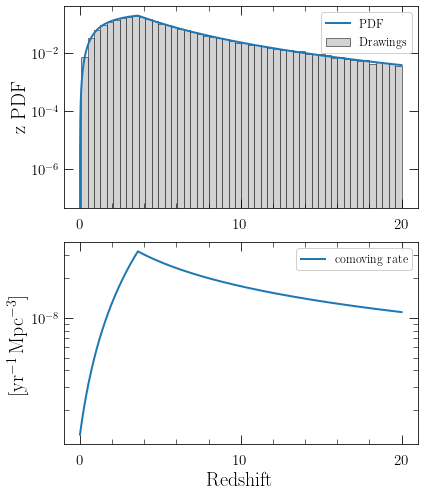

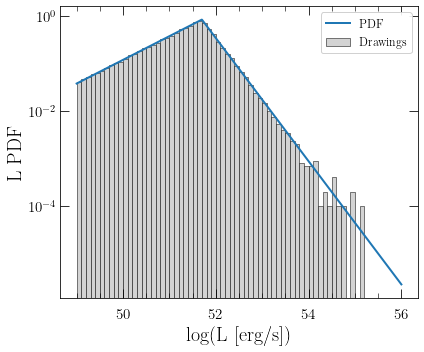

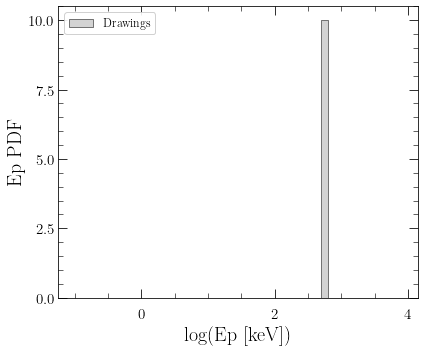

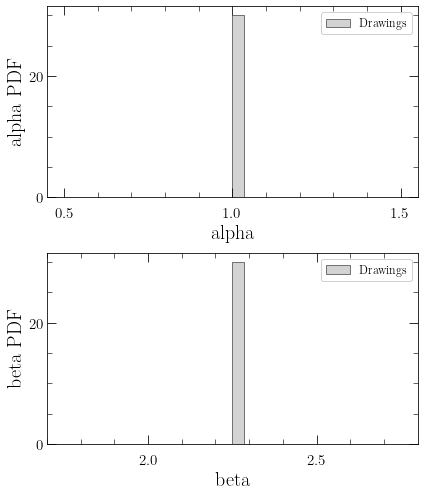

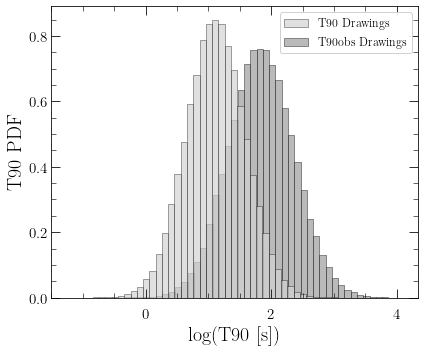

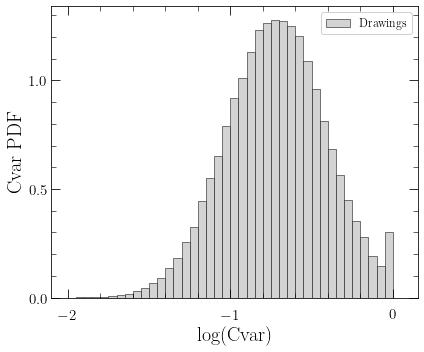

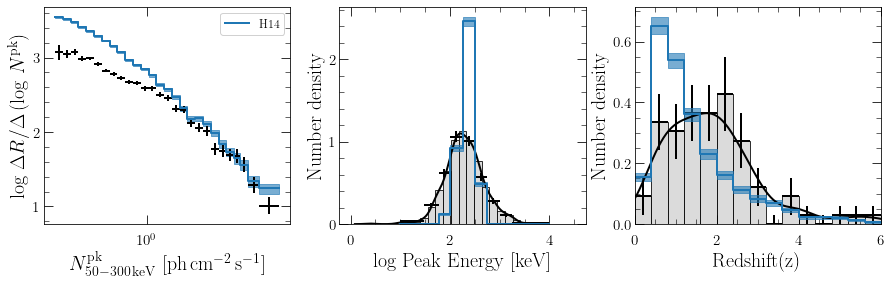

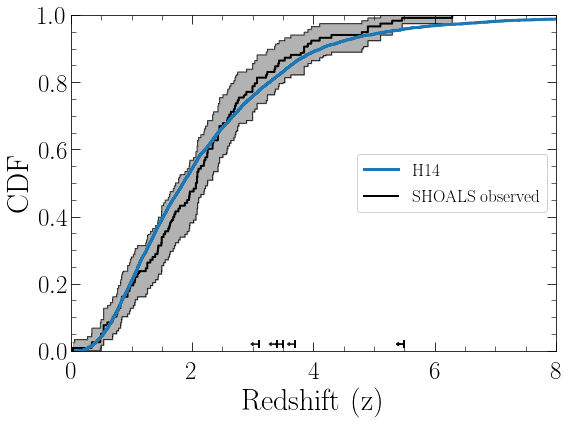

In [9]:
# Howell 2014
H14 = True
nGRB0 = 7.5e-10 # yr-1 Mpc-3
nGRB0_err = 0.5e-10 # yr-1 Mpc-3
if H14:
    lab = 'H14'
    color = 'crimson'
    paths_to_dir, paths_to_files = io.generate_paths()
    config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
    # Cosmology is slightly different
    cosmo = cs.create_cosmology(OmegaM=0.32, OmegaL=0.68, h=0.67, zmax=100)
    params['luminosity_function']={'model':'EBPL',
                                  'logLbreak':51.7,
                                  'slopeL':0.5,
                                  'slopeH':2.3,
                                  'logLmin':49,
                                  'logLmax':56,
                                  'k_evol':0.0}
    params['redshift_distribution']={'model':'BPL',
                                     'zm':3.6,
                                     'a':2.1,
                                     'b':-0.7}
    params['peak_energy_distribution']={'model':'Fixed',
                                        'Ep0':511.}
    params['spectral_shape']={'model':'FBand',
                                    'alpha':1,
                                    'beta':2.25}

    config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
    incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                           samples=samples,
                                                           instruments=instruments,
                                                           obs_constraints=obs_constraints)
    ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                ECLAIRs_config=instruments['ECLAIRs'])
    samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

    gp = GRBPopulation(Nb_GRBs=Nb_GRBs_glob)
    gp.draw_GRB_properties(cosmo, params, run_mode='debug')
    gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
    gp.calc_photon_fluence(incl_instruments)
    gp.calc_energy_fluence(incl_instruments)
    gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
    gp.create_mock_constraints()
#     gp.compare_to_observational_constraints(constraints=incl_constraints)
    gp.normalize_from(nGRB0=nGRB0, nGRB0_err=nGRB0_err)
    print(gp.summary())

    # Observational constraints
    plt.style.use('presentation')
    fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
    pf.plot_intensity_constraint(axes[0], pop=gp, label=lab)
#     pf.plot_intensity_constraint(axes[0], pop=gp, label='Alt', alt_norm=True, plot_obs=False)
    pf.plot_spectral_constraint(axes[1], pop=gp, label=lab)
    pf.plot_redshift_constraint(axes[2], pop=gp, label=lab)
    axes[0].legend()

    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{lab}.pdf', bbox_inches='tight')

    # SHOALS redshift distribution
    plt.style.use('paper')
    fig, ax = plt.subplots(figsize=(8,6))
    df = gp.properties
    pf.plot_SHOALS_distr(df[df['pdet_SHOALS']==1]['z'],
                          key='z',
                          plot_obs=False,
                          cumul=True,
                          ax=ax,
                          mod_color='C0',
                          mod_label=lab, linewidth=3)

    pf.plot_SHOALS_z_distr_with_bounds(ax)
    if save_fig:
        fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{lab}.pdf', bbox_inches='tight')


Creating cosmology with: OmegaM = 0.3, OmegaL = 0.7, H0 = 65.0
10:55:55.616 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
10:55:55.617 [INFO] Including instruments: ['BATSE', 'BAT']
10:55:55.618 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
10:55:55.734 [INFO] Starting calculations of peak photon fluxes...
10:55:56.678 [INFO] Starting calculations of peak photon fluxes...
10:55:57.633 [INFO] Starting calculations of peak energy fluxes...
10:55:59.465 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+05                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                            redshift_distribution                             |
----------------------------------------------------

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


10:56:01.611 [INFO] In compute_CDF_bounds_by_MC: plotting...
10:56:01.769 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
10:56:01.770 [INFO] Including instruments: ['BATSE', 'BAT']
10:56:01.771 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
10:56:01.857 [INFO] Starting calculations of peak photon fluxes...


/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


10:56:02.703 [INFO] Starting calculations of peak photon fluxes...
10:56:03.529 [INFO] Starting calculations of peak energy fluxes...
10:56:05.201 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+05                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                            redshift_distribution                             |
--------------------------------------------------------------------------------
|                                model = qD06                                  |
|                                  SFR = 2                                     |
|                                  mod = A                                     |
------------------------------------------------------------------

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


10:56:06.118 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
10:56:06.120 [INFO] Including instruments: ['BATSE', 'BAT']
10:56:06.121 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
10:56:06.237 [INFO] Starting calculations of peak photon fluxes...


/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


10:56:07.246 [INFO] Starting calculations of peak photon fluxes...
10:56:08.164 [INFO] Starting calculations of peak energy fluxes...
10:56:09.924 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+05                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                            redshift_distribution                             |
--------------------------------------------------------------------------------
|                                model = qD06                                  |
|                                  SFR = 3                                     |
|                                  mod = A                                     |
------------------------------------------------------------------

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/pa

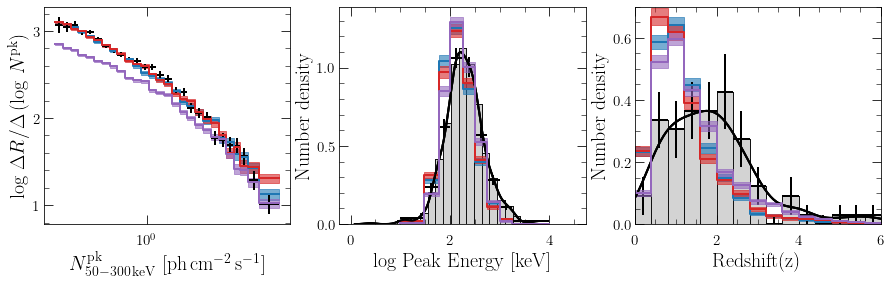

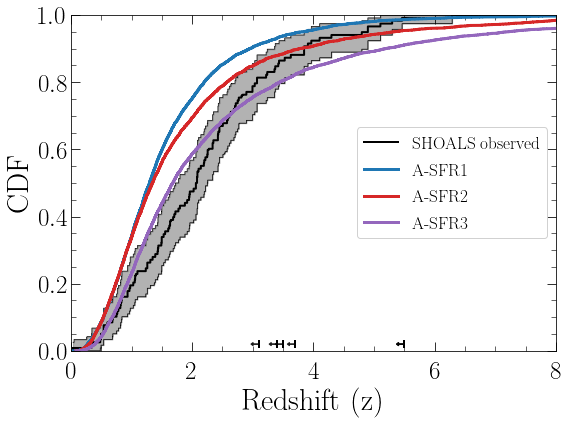

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


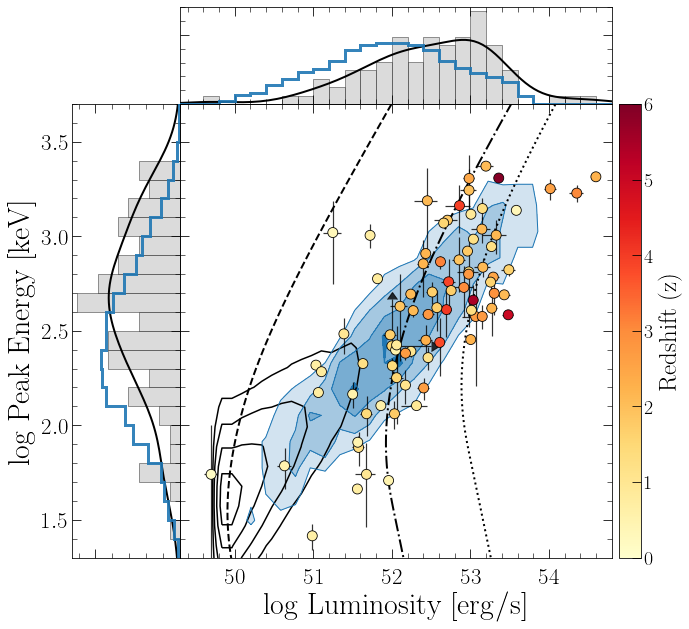

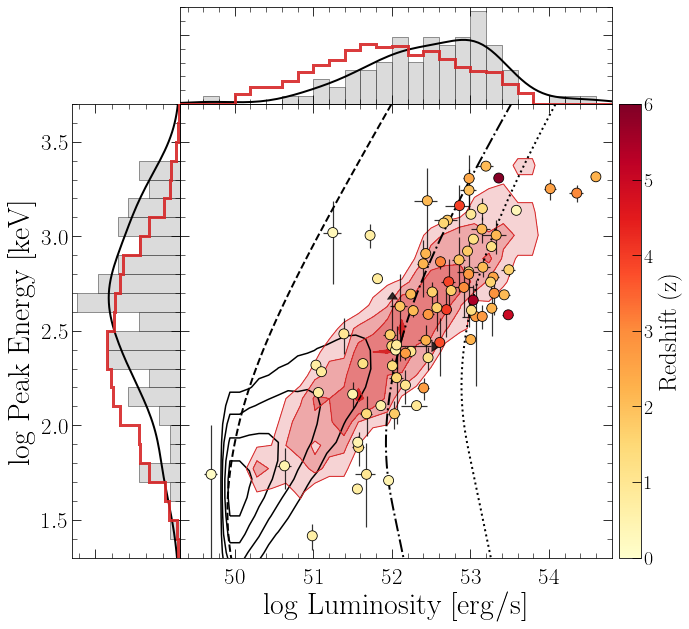

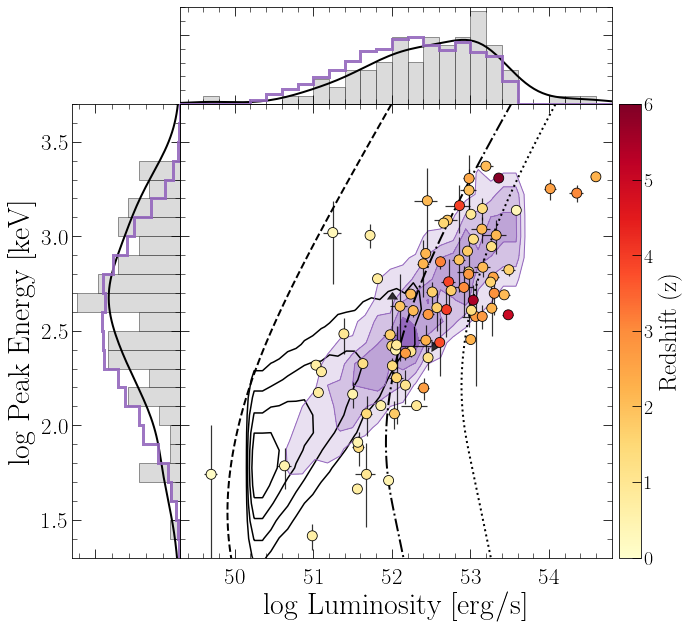

In [15]:
# Daigne 2006 for Amati-like relation
D06 = True
slopes = [1.70, 1.68, 1.54]
logLmins = [49.9, 50.0, 50.3]
logLmaxs = [53.7, 53.7, 53.5]
a_s = [0.320, 0.196, 0.175]
b_s = [3.30, 4.0, 3.67]
c_s = [3.52, 4.0, 3.58]
d_s = [23.6, 14.6, 12.6]
nGRB0_s = np.asarray([6.348e-10, 4.905e-10, 1.570e-10])
nGRB0_err_s = 0.3*nGRB0_s
labels = ['A-SFR1', 'A-SFR2', 'A-SFR3']
colors = ['C0', 'C3', 'C4']
if D06:
    paths_to_dir, paths_to_files = io.generate_paths()
    cosmo = cs.create_cosmology(OmegaM=0.3, OmegaL=0.7, h=0.65, zmax=100)
    for i in range(len(slopes)):
        config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
        config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
        # Cosmology is slightly different
        params['luminosity_function']={'model':'EPL',
                                      'logLmin':logLmins[i],
                                      'logLmax':logLmaxs[i],
                                      'slope':slopes[i],
                                      'k_evol':0.0}
        params['redshift_distribution']={'model':'qD06',
                                        'SFR':i+1,
                                        'mod':'A'}
        params['peak_energy_distribution']={'model':'A',
                                            'Ep0':380.,
                                            'alpha_amati':0.43,
                                            'sigmaEp':0.2}
        params['spectral_shape']={'model':'GBM_Band'}

        incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                               samples=samples,
                                                               instruments=instruments,
                                                               obs_constraints=obs_constraints)
        ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                    ECLAIRs_config=instruments['ECLAIRs'])
        samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

        gp = GRBPopulation(Nb_GRBs=Nb_GRBs_glob)
        gp.draw_GRB_properties(cosmo, params)
        gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_photon_fluence(incl_instruments)
        gp.calc_energy_fluence(incl_instruments)
        gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
        gp.create_mock_constraints()
#         gp.compare_to_observational_constraints(constraints=incl_constraints)
        gp.normalize_from(nGRB0=nGRB0_s[i], nGRB0_err=nGRB0_err_s[i])
        print(gp.summary())

        # Observational constraints
        plt.style.use('presentation')
        if i == 0:
            fig_cstr, axes_cstr = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
        pf.plot_intensity_constraint(axes_cstr[0], pop=gp, label=labels[i], color=colors[i])
        pf.plot_spectral_constraint(axes_cstr[1], pop=gp, label=labels[i], color=colors[i])
        pf.plot_redshift_constraint(axes_cstr[2], pop=gp, label=labels[i], color=colors[i])

        if save_fig:
            fig_cstr.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{labels[i]}.pdf', bbox_inches='tight')

        # SHOALS redshift distribution
        plt.style.use('paper')
        if i == 0:
            fig_SHOALS, ax_SHOALS = plt.subplots(figsize=(8,6))
            pf.plot_SHOALS_z_distr_with_bounds(ax_SHOALS)
        df = gp.properties
        pf.plot_SHOALS_distr(df[df['pdet_SHOALS']==1]['z'],
                              key='z',
                              plot_obs=False,
                              cumul=True,
                              ax=ax_SHOALS,
                              mod_color=colors[i],
                              mod_label=labels[i], linewidth=3)

        if save_fig:
            fig_SHOALS.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{labels[i]}.pdf', bbox_inches='tight')

        plt.style.use('paper')
        df = gp.properties
        cond = df['pht_pflx_BAT'] >= 2.6
        fig, axes = pf.cool_hist2d(np.log10(df['L'].to_numpy()), np.log10(df['Ep'].to_numpy()),
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       plot_left_hist=False, plot_top_hist=False,
                       hist2d_kwargs={'color':'k', 'bins':30, 
                                      'contour_kwargs':{'linewidths':1.5, 'zorder':2},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':False})
        pf.cool_hist2d(np.log10(df[cond]['L'].to_numpy()), np.log10(df[cond]['Ep'].to_numpy()), fig=fig,
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       left_hist_kwargs={'label': None,
                                         'bins':np.linspace(1,4,31),
                                         'edgecolor':colors[i],
                                         'linewidth':3,
                                         'zorder':5,
                                         'alpha':0.9,
                                         'histtype':'step'},
                       top_hist_kwargs={'label': None,
                                        'bins': np.linspace(49,55,31),
                                        'edgecolor': colors[i],
                                        'linewidth':3,
                                        'zorder':5,
                                        'alpha':0.9,
                                        'histtype':'step'},
                       hist2d_kwargs={'color':colors[i], 'label':labels[i],
                                      'contour_kwargs':{'linewidths':1},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':True})
        pf.plot_eBAT6_EpL_for_pub(axes=axes, mini_cax=False, show_relation=False)
        if save_fig:
            fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/eBAT6_EpL_{labels[i]}.pdf', bbox_inches='tight')


Creating cosmology with: OmegaM = 0.3, OmegaL = 0.7, H0 = 65.0
11:01:33.627 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
11:01:33.628 [INFO] Including instruments: ['BATSE', 'BAT']
11:01:33.629 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
11:01:33.727 [INFO] Starting calculations of peak photon fluxes...
11:01:34.648 [INFO] Starting calculations of peak photon fluxes...
11:01:35.499 [INFO] Starting calculations of peak energy fluxes...
11:01:37.223 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+05                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                            redshift_distribution                             |
----------------------------------------------------

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


11:01:39.378 [INFO] In compute_CDF_bounds_by_MC: plotting...
11:01:39.563 [INFO] Including samples: ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
11:01:39.565 [INFO] Including instruments: ['BATSE', 'BAT']
11:01:39.566 [INFO] Including constraints: ['Stern', 'EpGBM', 'eBAT6']
11:01:39.657 [INFO] Starting calculations of peak photon fluxes...


/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/distributions.py:338: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set_xlim(0, auto=None)


11:01:40.635 [INFO] Starting calculations of peak photon fluxes...
11:01:41.604 [INFO] Starting calculations of peak energy fluxes...
11:01:43.426 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+05                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                            redshift_distribution                             |
--------------------------------------------------------------------------------
|                                model = qD06                                  |
|                                  SFR = 2                                     |
|                                  mod = LN                                    |
------------------------------------------------------------------

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/pa

11:01:44.205 [INFO] Starting calculations of peak photon fluxes...
11:01:45.072 [INFO] Starting calculations of peak photon fluxes...
11:01:45.881 [INFO] Starting calculations of peak energy fluxes...
11:01:47.518 [INFO] Starting calculations of detection probability...

|                                   SUMMARY                                    |
|                              Nb_GRBs = 1.00e+05                              |
|                     Output directory = ipynb_codes                           |
|                                  Parameters                                  |
|                            redshift_distribution                             |
--------------------------------------------------------------------------------
|                                model = qD06                                  |
|                                  SFR = 3                                     |
|                                  mod = LN                                    |

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:51: RuntimeWarning: invalid value encountered in log10
  log_x[0] = np.log10(x[0])
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:52: RuntimeWarning: invalid value encountered in log10
  log_x[1] = np.log10(x[0] + x[1]) - log_x[0]
/Users/palmerio/Science_projects/GRB_population_model/src/miscellaneous.py:53: RuntimeWarning: invalid value encountered in log10
  log_x[2] = log_x[0] - np.log10(x[0] - x[2])
/Users/pa

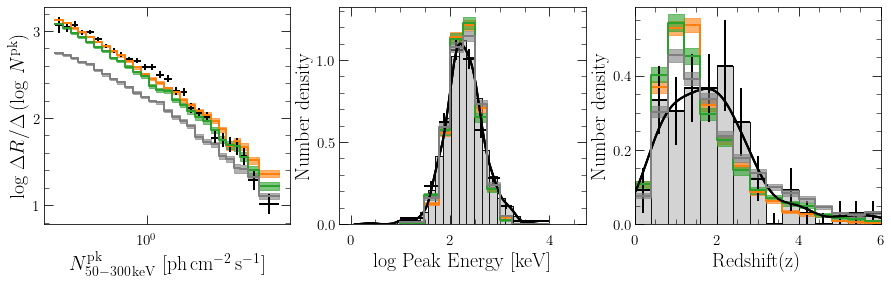

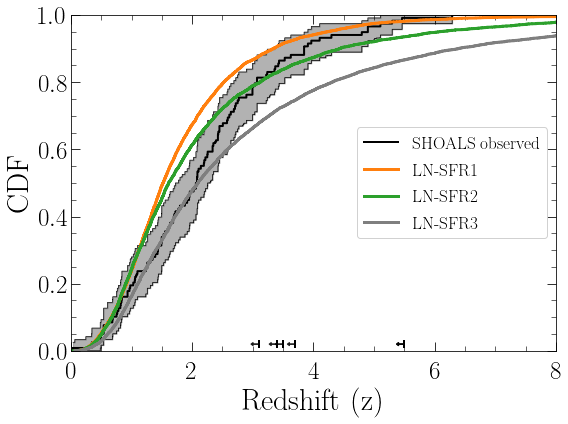

/Users/palmerio/miniconda3/envs/python3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


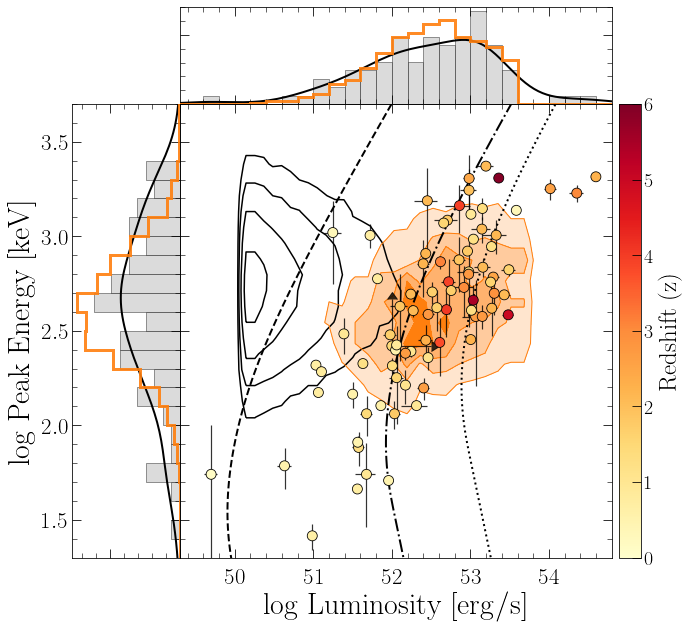

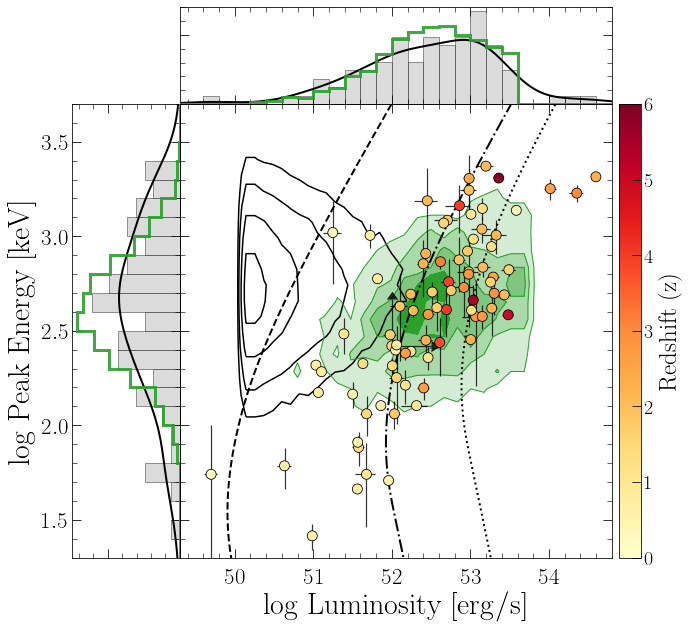

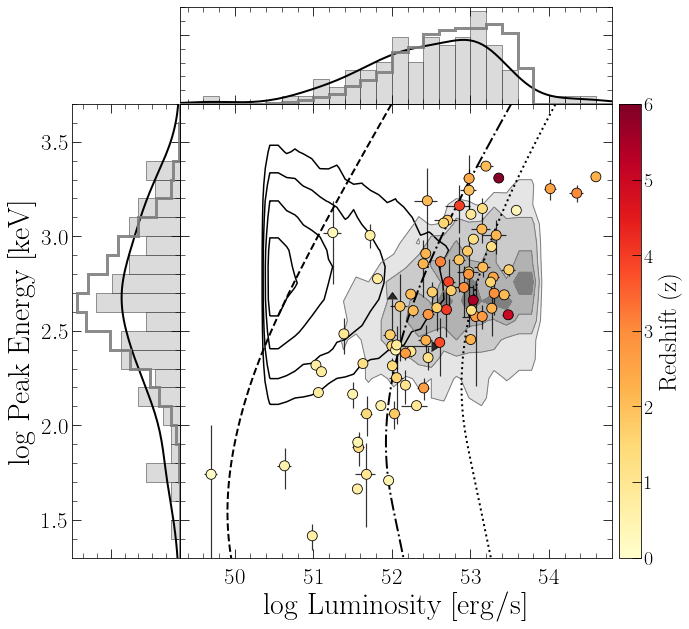

In [16]:
# Daigne 2006 for LogNormal relation
D06 = True
slopes = [1.62, 1.62, 1.52]
logLmins = [50.2, 50.2, 50.5]
logLmaxs = [53.6, 53.6, 53.7]
Ep0s = [10**2.74, 10**2.73, 10**2.79]
a_s = [0.320, 0.196, 0.175]
b_s = [3.30, 4.0, 3.67]
c_s = [3.52, 4.0, 3.58]
d_s = [23.6, 14.6, 12.6]
nGRB0_s = np.asarray([3.967e-10, 3.066e-10, 9.890e-11])
nGRB0_err_s = 0.3*nGRB0_s
labels = ['LN-SFR1', 'LN-SFR2', 'LN-SFR3']
colors = ['C1', 'C2', 'C7']
if D06:
    paths_to_dir, paths_to_files = io.generate_paths()
    cosmo = cs.create_cosmology(OmegaM=0.3, OmegaL=0.7, h=0.65, zmax=100)
    for i in range(len(slopes)):
        config, params, instruments, samples, obs_constraints = io.read_init_files(paths_to_files)
        config['samples'] = ['Stern', 'EpGBM', 'eBAT6', 'SHOALS']
        # Cosmology is slightly different
        params['luminosity_function']={'model':'EPL',
                                      'logLmin':logLmins[i],
                                      'logLmax':logLmaxs[i],
                                      'slope':slopes[i],
                                      'k_evol':0.0}
        params['redshift_distribution']={'model':'qD06',
                                         'SFR':i+1,
                                         'mod':'LN'}
        params['peak_energy_distribution']={'model':'LN',
                                            'Ep0':Ep0s[i],
                                            'sigmaEp':0.3}
        params['spectral_shape']={'model':'GBM_Band'}

        incl_samples, incl_instruments, incl_constraints = io.create_config(config=config,
                                                               samples=samples,
                                                               instruments=instruments,
                                                               obs_constraints=obs_constraints)
        ECLAIRs_prop = init_ECLAIRs(ECLAIRs_dir=paths_to_dir['ECLAIRs'],
                                    ECLAIRs_config=instruments['ECLAIRs'])
        samples['ECLAIRs']['pflx_min'] = ECLAIRs_prop['bkg_total']

        gp = GRBPopulation(Nb_GRBs=Nb_GRBs_glob)
        gp.draw_GRB_properties(cosmo, params)
        gp.calc_peak_photon_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_peak_energy_flux(incl_instruments, ECLAIRs_prop=ECLAIRs_prop)
        gp.calc_photon_fluence(incl_instruments)
        gp.calc_energy_fluence(incl_instruments)
        gp.calc_det_prob(incl_samples, **ECLAIRs_prop)
        gp.create_mock_constraints()
#         gp.compare_to_observational_constraints(constraints=incl_constraints)
        gp.normalize_from(nGRB0=nGRB0_s[i], nGRB0_err=nGRB0_err_s[i])
        print(gp.summary())

        # Observational constraints
        plt.style.use('presentation')
        if i == 0:
            fig_cstr, axes_cstr = plt.subplots(1,3, figsize=(15,4), tight_layout=False)
        pf.plot_intensity_constraint(axes_cstr[0], pop=gp, label=labels[i], color=colors[i])
        pf.plot_spectral_constraint(axes_cstr[1], pop=gp, label=labels[i], color=colors[i])
        pf.plot_redshift_constraint(axes_cstr[2], pop=gp, label=labels[i], color=colors[i])

        if save_fig:
            fig_cstr.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/constraints_{labels[i]}.pdf', bbox_inches='tight')

        # SHOALS redshift distribution
        plt.style.use('paper')
        if i == 0:
            fig_SHOALS, ax_SHOALS = plt.subplots(figsize=(8,6))
            pf.plot_SHOALS_z_distr_with_bounds(ax_SHOALS)
        df = gp.properties
        pf.plot_SHOALS_distr(df[df['pdet_SHOALS']==1]['z'],
                              key='z',
                              plot_obs=False,
                              cumul=True,
                              ax=ax_SHOALS,
                              mod_color=colors[i],
                              mod_label=labels[i], linewidth=3)

        if save_fig:
            fig_SHOALS.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/SHOALS_z_distr_{labels[i]}.pdf', bbox_inches='tight')

        plt.style.use('paper')
        df = gp.properties
        cond = df['pht_pflx_BAT'] >= 2.6
        fig, axes = pf.cool_hist2d(np.log10(df['L'].to_numpy()), np.log10(df['Ep'].to_numpy()),
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       plot_left_hist=False, plot_top_hist=False,
                       hist2d_kwargs={'color':'k', 'bins':30, 
                                      'contour_kwargs':{'linewidths':1.5, 'zorder':2},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':False})
        pf.cool_hist2d(np.log10(df[cond]['L'].to_numpy()), np.log10(df[cond]['Ep'].to_numpy()), fig=fig,
                       mode='hist2d', figsize=(10,9), plot_left_kdeplot=False, plot_top_kdeplot=False,
                       left_hist_kwargs={'label': None,
                                         'bins':np.linspace(1,4,31),
                                         'edgecolor':colors[i],
                                         'linewidth':3,
                                         'zorder':5,
                                         'alpha':0.9,
                                         'histtype':'step'},
                       top_hist_kwargs={'label': None,
                                        'bins': np.linspace(49,55,31),
                                        'edgecolor': colors[i],
                                        'linewidth':3,
                                        'zorder':5,
                                        'alpha':0.9,
                                        'histtype':'step'},
                       hist2d_kwargs={'color':colors[i], 'label':labels[i],
                                      'contour_kwargs':{'linewidths':1},
                                      'plot_datapoints':False, 
                                      'plot_density':False, 
                                      'plot_contours':True,
                                      'fill_contours':True})
        pf.plot_eBAT6_EpL_for_pub(axes=axes, mini_cax=False, show_relation=False)
        if save_fig:
            fig.savefig(f'/Users/palmerio/Science_projects/Papers/LGRB_population_model/plots/eBAT6_EpL_{labels[i]}.pdf', bbox_inches='tight')
